In [1]:
%pylab inline
import numpy as np
import torch
from tqdm import trange

# needed otherwise imshow kills kernel
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

Populating the interactive namespace from numpy and matplotlib


In [2]:
with open("./Data_MNIST/train-images.idx3-ubyte", "rb") as f:
    dat=f.read()
    X_train = np.frombuffer(dat,dtype = np.uint8)[0x10:].reshape(-1,28,28)
with open("./Data_MNIST/train-labels.idx1-ubyte", "rb") as f:
    dat=f.read()
    Y_train = np.frombuffer(dat,dtype = np.uint8)[8:]
    
with open("./Data_MNIST/t10k-labels.idx1-ubyte", "rb") as f:
    dat=f.read()
    Y_test = np.frombuffer(dat,dtype = np.uint8)[8:]
with open("./Data_MNIST/t10k-images.idx3-ubyte", "rb") as f:
    dat=f.read()
    X_test = np.frombuffer(dat,dtype = np.uint8)[0x10:].reshape(-1,28,28)

(<matplotlib.image.AxesImage at 0x1f1a61dea08>, 5)

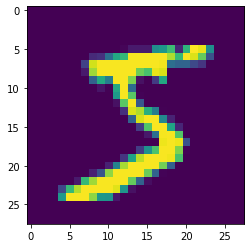

In [3]:
imshow(X_train[0]), Y_train[0]

In [4]:
import torch.nn as nn
import torch.nn.functional as F
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(784,128, bias = False)
        self.l2 = nn.Linear(128,10, bias = False)
        self.sm = nn.LogSoftmax(dim=1)
        
    def forward(self,x):
        x = F.relu(self.l1(x))
        x = self.l2(x)
        x = self.sm(x)
        return x
    
model = Model()

In [5]:
np.argmax(model(torch.tensor(X_train[0]).reshape(-1,28*28).float()).detach().numpy())

6

loss 0.21 accuracy 0.93: 100%|████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 193.29it/s]


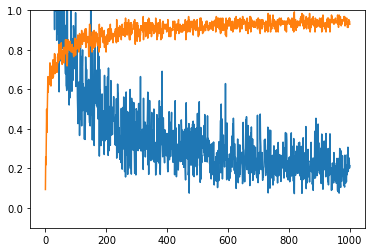

In [6]:
model = Model()
BS = 128
loss_fn = nn.CrossEntropyLoss()
losses,accuracies = [], []
optim = torch.optim.SGD(model.parameters(),lr = 0.001)

t = trange(1000)
for i in t:
    samp = random.randint(0,X_train.shape[0],BS)
    X = torch.tensor(X_train[samp]).reshape(-1,28*28).float()
    Y = torch.tensor(Y_train[samp]).long()
    
    model.zero_grad()
    out = model(X)
    loss = loss_fn(out,Y)
    cat = torch.argmax(out, dim = 1)
    accuracy = (cat == Y).float().mean()
    loss.backward()
    optim.step()
    
    loss, accuracy = loss.item(), accuracy.item()
    losses.append(loss)
    accuracies.append(accuracy)
    t.set_description("loss %.2f accuracy %.2f" % (loss, accuracy))

plt.ylim(-0.1,1)
plot(losses)
plot(accuracies)

In [7]:
Y_test_preds = torch.argmax(model(torch.tensor(X_test).reshape(-1,28*28).float()),dim = 1).numpy()
(Y_test == Y_test_preds).mean()

0.9303

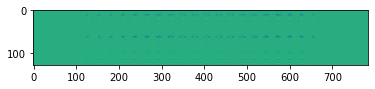

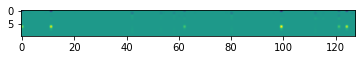

In [8]:
# compute gradients
samp = [0,1,2,3]
model.zero_grad()
out = model(torch.tensor(X_test[samp].reshape(-1,28*28)).float())
out.retain_grad()
loss = loss_fn(out, torch.tensor(Y_test[samp]).long()).mean()
loss.retain_grad()
loss.backward()
imshow(model.l1.weight.grad)
figure()
imshow(model.l2.weight.grad)

In [9]:
l1 = model.l1.weight.detach().numpy().T
l2 = model.l2.weight.detach().numpy().T

def forward(x):
    x = x.dot(l1)
    x = np.maximum(x,0)
    x = x.dot(l2)
    return x

def numpy_eval_acc():
    Y_test_preds_out = forward(X_test.reshape(-1,28*28))
    Y_test_preds = np.argmax(Y_test_preds_out, axis = 1)
    
    return (Y_test_preds == Y_test).mean()

In [10]:
numpy_eval_acc()

0.9303

In [11]:
def logsumexp(x):
    c = x.max(axis = 1)
    return c + np.log(np.exp(x - c.reshape((-1,1))).sum(axis = 1))

def forward_backward(x,y):
    out = np.zeros((len(y),10), np.float32)
    out[range(len(y)), y] = 1
    
    x_l1 = x.dot(l1)
    x_relu = np.maximum(x_l1,0)
    x_l2 = x_relu.dot(l2)
    x_lsm = x_l2 - logsumexp(x_l2).reshape((-1,1))
    x_loss = (-out * x_lsm).mean()
    
    #backward pass, compute derivatives
    
    d_loss = -out/len(y)
    d_lsm = d_loss - np.exp(x_lsm)*d_loss.sum(axis=1).reshape((-1,1))
    d_l2 = x_relu.T.dot(d_lsm)
    dx_l2 = d_lsm.dot(l2.T)
    d_relu = (x_relu>0).astype(np.float32)*dx_l2
    d_l1 = x.T.dot(d_relu)
    return x_loss, x_l2,d_l1,d_l2
    

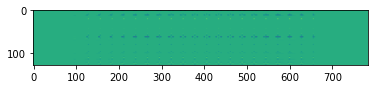

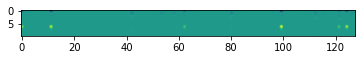

In [12]:
samp = [0,1,2,3]
x_loss , x_l2,d_l1,d_l2 = forward_backward(X_test[samp].reshape((-1,28*28)),Y_test[samp])

imshow(d_l1.T)
figure()
imshow(d_l2.T)

In [14]:
def layer_init_glorot(m,n):
    return np.random.randn(m,n)/np.sqrt(m)
def layer_init_uniform(m,n):
    return np.random.uniform(-1.,1.,size = (m,n))/np.sqrt(m*n)

loss 0.00 accuracy 0.97: 100%|████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 206.59it/s]


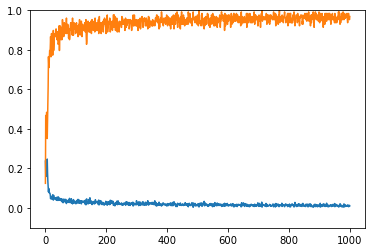

In [15]:
np.random.seed(100)
l1 = layer_init_uniform(784,128)
l2 = layer_init_uniform(128,10)

lr = 0.001
BS = 128

losses,accuracies = [], []

t = trange(1000)
for i in t:
    samp = random.randint(0,X_train.shape[0],BS)
    X = X_train[samp].reshape(-1,28*28)
    Y = Y_train[samp]
    
    x_loss , x_l2,d_l1,d_l2 = forward_backward(X,Y)

    
    cat = np.argmax(x_l2, axis = 1)
    accuracy = (cat == Y).mean()
    
    l1 = l1 - lr *d_l1
    l2 = l2 -lr * d_l2
    losses.append(x_loss)
    
    accuracies.append(accuracy)

    t.set_description("loss %.2f accuracy %.2f" % (loss, accuracy))

plt.ylim(-0.1,1)
plot(losses)
plot(accuracies)

In [16]:
numpy_eval_acc()

0.9619

In [17]:
x_loss , x_l2,d_l1,d_l2 = forward_backward(X_test[:100].reshape((-1,28*28)),Y_test[:100])

In [18]:
y=np.argmax(forward(X_test[:100].reshape((-1,28*28))),axis=1)
err = 1-(y==Y_test[:100])

In [31]:
true_pred = y[err==1]
err_pred = forward(X_test[:100].reshape((-1,28*28)))[err==1,:]

6 5
2 3


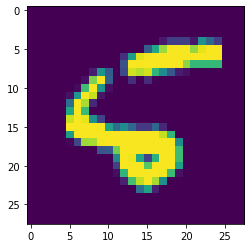

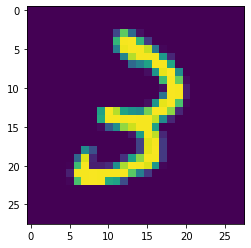

In [39]:
for x in range(len(true_pred)):
    print(np.argmax(err_pred[x]), Y_test[:100][err==1][x])
    figure()
    imshow(X_test[:100][err==1,:][x])
